In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [1]:
!wget "https://raw.githubusercontent.com/Rouzbehrahimi/Advanced_python/master/hour.csv"

--2019-05-16 14:34:15--  https://raw.githubusercontent.com/Rouzbehrahimi/Advanced_python/master/hour.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.0.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1156736 (1.1M) [text/plain]
Saving to: 'hour.csv'

hour.csv            100%[===================>]   1.10M  3.13MB/s    in 0.4s    

2019-05-16 14:34:16 (3.13 MB/s) - 'hour.csv' saved [1156736/1156736]



In [5]:
df_dask=dd.read_csv("hour.csv")
df_dask=df_dask.set_index('instant')
df_dask=df_dask.repartition(npartitions=10)
df_dask.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## 1.EDA

###  1.1. Identifying null values
##### According to the below the code this dataset does not have any null value.

In [6]:
df_dask.isnull().sum().compute()

dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [7]:
df_dask=df_dask.rename(
    columns={
        "dteday": "datetime",
        "weathersit": "weather_condition",
        "cnt": "total_bike_rented",
    }
)

In [8]:
df_dask['datetime']= dd.to_datetime(df_dask.datetime, format='%Y-%m-%d')

In [9]:
features_to_transform = [
    "season",
    "yr",
    "mnth",
    "hr",
    "holiday",
    "weekday",
    "workingday",
    "weather_condition",
]

In [10]:
def type_shifter(df, features, new_type):
    """this function takes the selected features of a data frame and 
    cast them to the new_type"""
    for i in features:
        df[i] = df[i].astype(new_type)
    return df.info()

In [11]:
type_shifter(df_dask, features_to_transform, "category")

<class 'dask.dataframe.core.DataFrame'>
Columns: 16 entries, datetime to total_bike_rented
dtypes: category(8), datetime64[ns](1), float64(4), int64(3)

### Renaming the categorical variables' levels:

#### In the priginal dataset all the weekdays and months are presented as integer, although we have already casted them to categorical type, in order to make them more informative, we would change the levels' names:

In [12]:
df_dask["weekday"] = df_dask["weekday"].map(
    {
        0: "Sunday",
        1: "Monday",
        2: "Tuesday",
        3: "Wednesday",
        4: "Thursday",
        5: "Friday",
        6: "Saturday",
    }
)

**Here we will check which season is which numbner based on the unique months based on that season**

In [13]:
df_dask[df_dask["season"] == 1]["mnth"].unique().compute()  # Seems like Winter

0     1
1     2
2     3
3    12
Name: mnth, dtype: category
Categories (4, int64): [1, 2, 3, 12]

In [14]:
df_dask[df_dask["season"] == 2]["mnth"].unique().compute()  # Seems like Spring

0    3
1    4
2    5
3    6
Name: mnth, dtype: category
Categories (4, int64): [3, 4, 5, 6]

In [15]:
df_dask[df_dask["season"] == 3]["mnth"].unique().compute()  # Seems like Summer

0    6
1    7
2    8
3    9
Name: mnth, dtype: category
Categories (4, int64): [6, 7, 8, 9]

In [16]:
df_dask[df_dask["season"] == 4]["mnth"].unique().compute()  # Seems like Autumn

0     9
1    10
2    11
3    12
Name: mnth, dtype: category
Categories (4, int64): [9, 10, 11, 12]

In [17]:
df_dask["season"] = df_dask["season"].map({1: "Winter", 2: "Spring", 3: "Summer", 4: "Autumn"})

In [18]:
df_dask["mnth"] = df_dask["mnth"].map(
    {
        1: "01-Jan",
        2: "02-Feb",
        3: "03-Mar",
        4: "04-Apr",
        5: "05-May",
        6: "06-Jun",
        7: "07-Jul",
        8: "08-Aug",
        9: "09-Sep",
        10: "10-Oct",
        11: "11-Nov",
        12: "12-Dec",
    }
)

In [19]:
df_dask["yr"] = df_dask["yr"].map({0: "2011", 1: "2012"})

In [20]:
df_dask["weather_condition"] = df_dask["weather_condition"].map({1: "A", 2: "B", 3: "C", 4: "D"})

In [21]:
df_dask.head()

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weather_condition,temp,atemp,hum,windspeed,casual,registered,total_bike_rented
instant,,,,,,,,,,,,,,,,
1,2011-01-01,Winter,2011,01-Jan,0,0,Saturday,0,A,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,Winter,2011,01-Jan,1,0,Saturday,0,A,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,Winter,2011,01-Jan,2,0,Saturday,0,A,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,Winter,2011,01-Jan,3,0,Saturday,0,A,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,Winter,2011,01-Jan,4,0,Saturday,0,A,0.24,0.2879,0.75,0.0,0,1,1


### Visualization
#### In order to see if there is any specific trend in different time intervals we present the target variable over month, day and hour to get a more clear vision of the target variable evolution.

In [22]:
sns.set_style("whitegrid")
sns.set_context("talk")
params = {
    "legend.fontsize": "large",
    "figure.figsize": (30, 10),
    "axes.labelsize": "large",
    "axes.titlesize": "large",
    "xtick.labelsize": "large",
    "ytick.labelsize": "large",
}

plt.rcParams.update(params)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


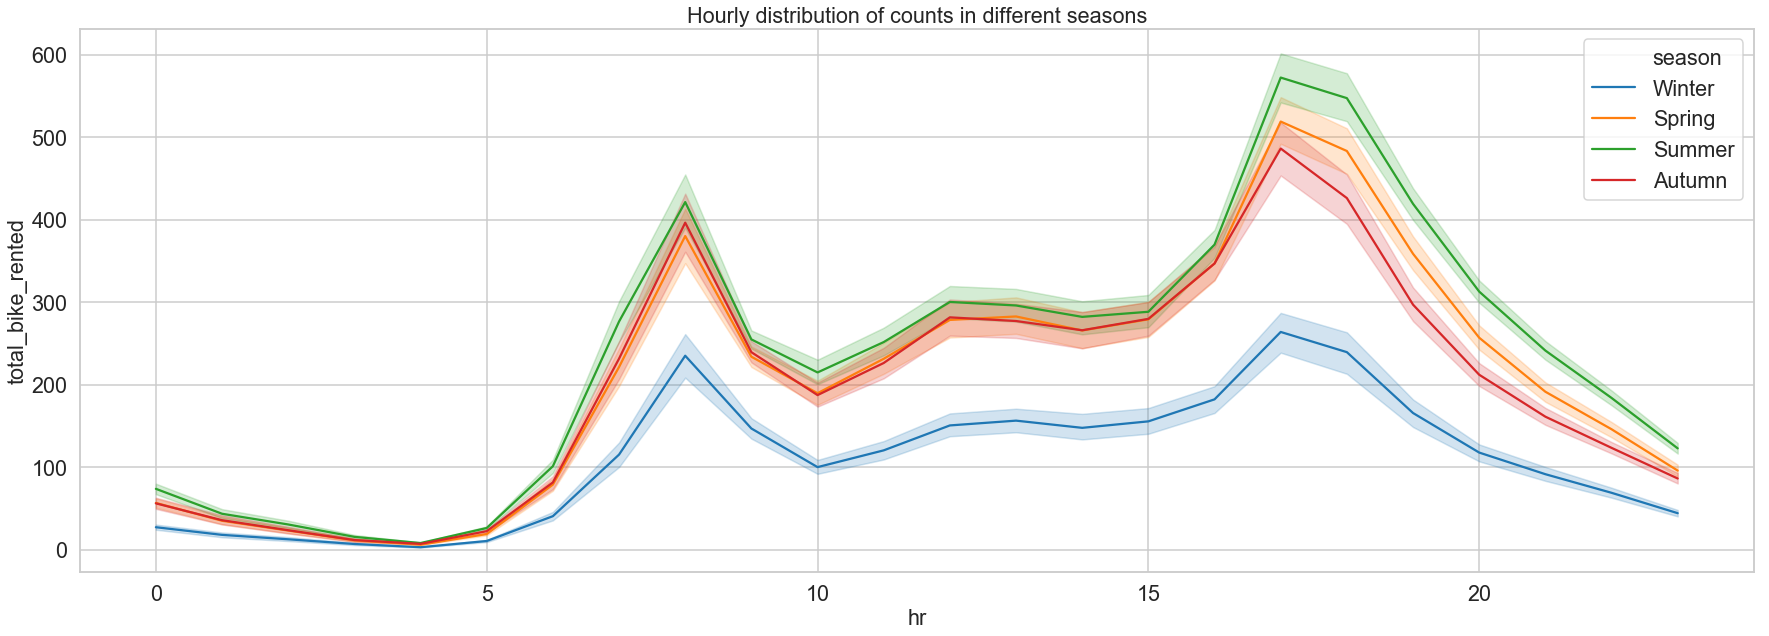

In [23]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df_dask[["hr", "total_bike_rented", "season"]].compute(),
    x="hr",
    y="total_bike_rented",
    hue="season",
    ax=ax,
    
)
ax.set(title="Hourly distribution of counts in different seasons");


#### The above graph shows that bike rental business is fairly seasonal and aslo correlated with the day time.

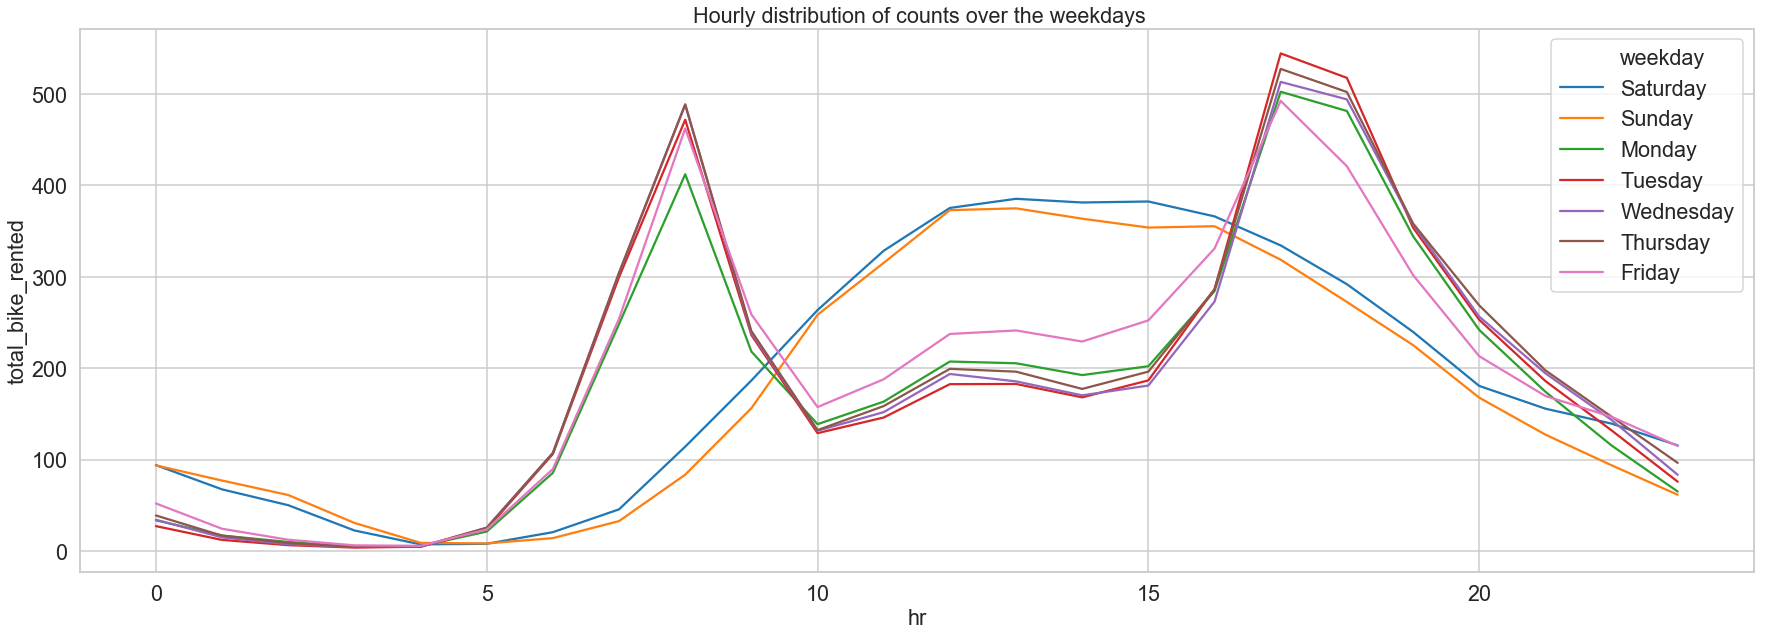

In [24]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df_dask[["hr", "total_bike_rented", "weekday"]].compute(),
    x="hr",
    y="total_bike_rented",
    hue="weekday",
    ax=ax,
    err_style=None,
)
ax.set(title=" Hourly distribution of counts over the weekdays");

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


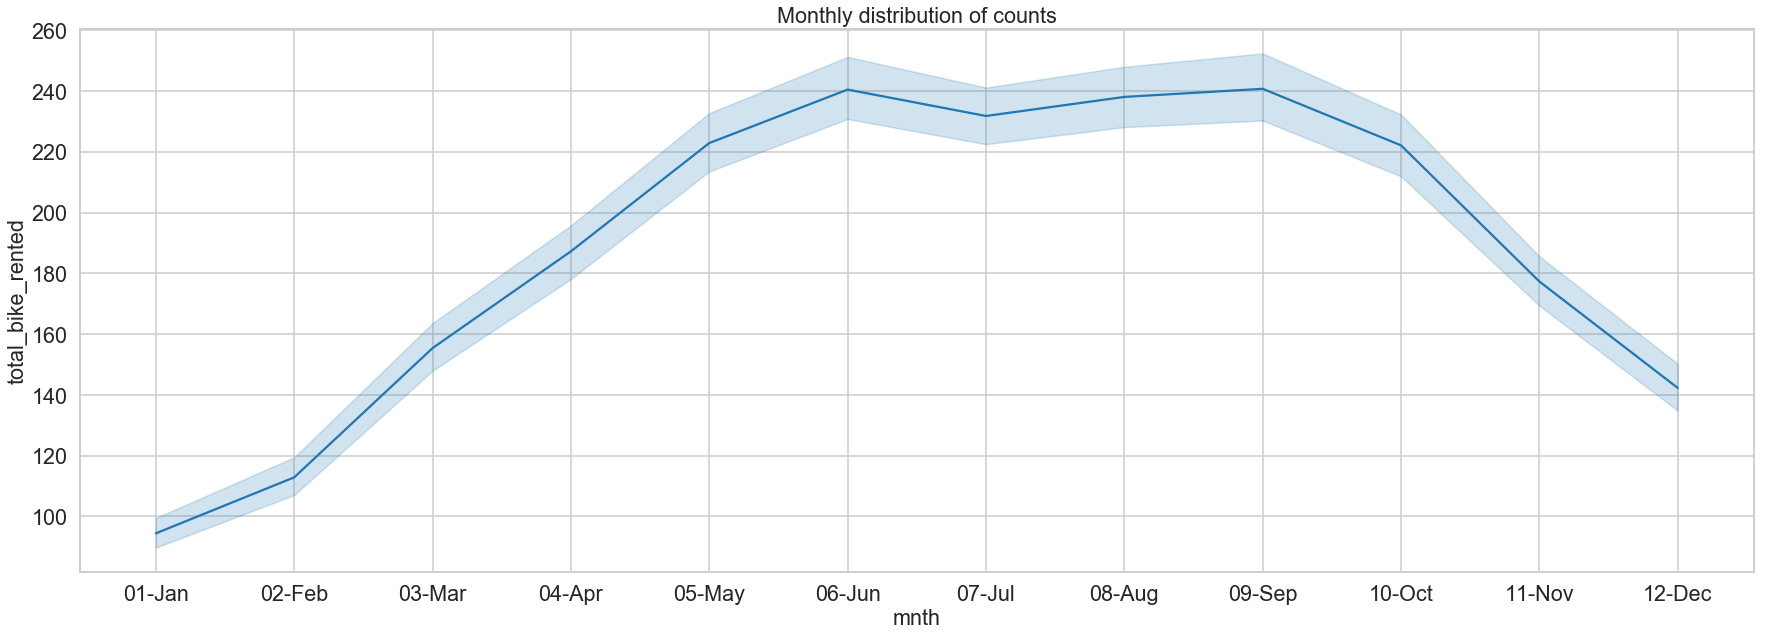

In [25]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df_dask[["mnth", "total_bike_rented", "yr"]].compute(), x="mnth", y="total_bike_rented", ax=ax
)
ax.set(title="Monthly distribution of counts");

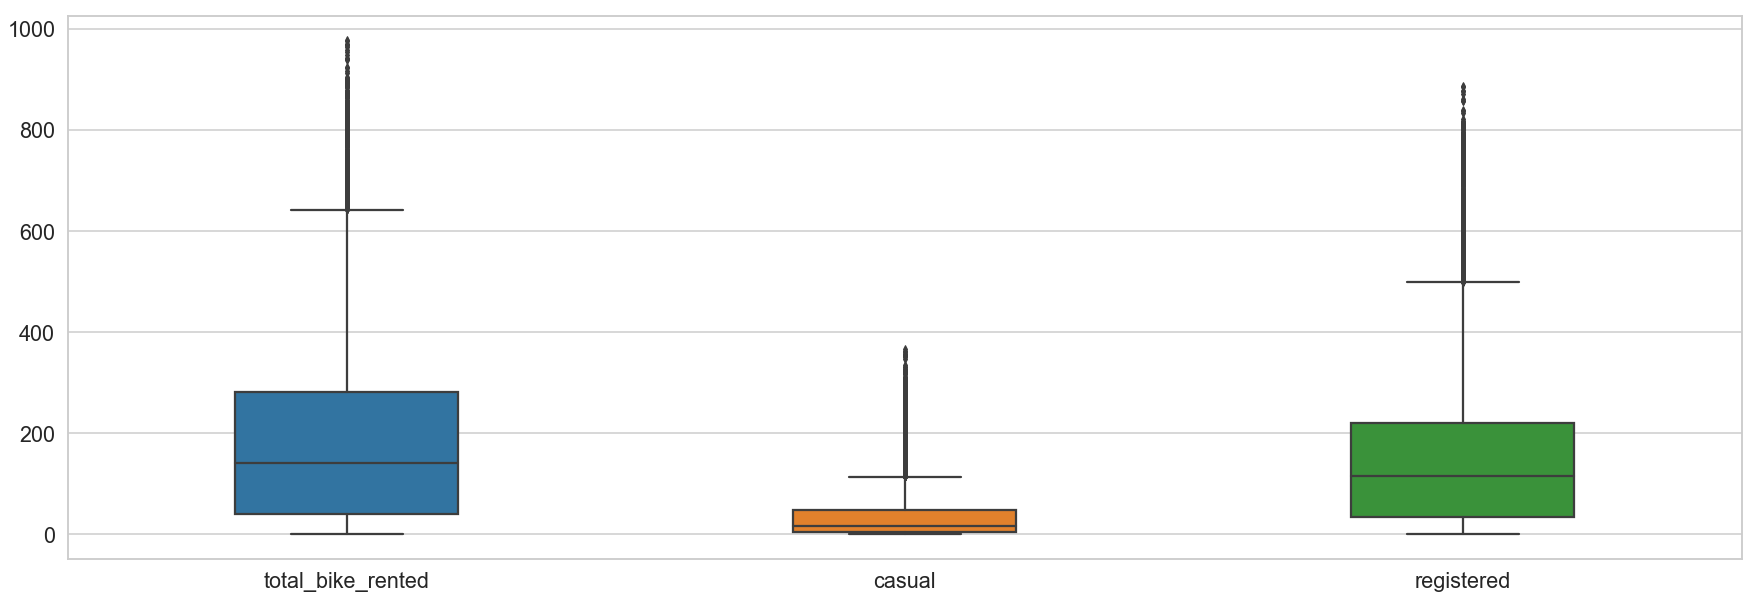

In [26]:
fig, ax = plt.subplots()
sns.boxplot(data=df_dask[["total_bike_rented", "casual", "registered"]].compute(), ax=ax, width=0.4);